In [1]:
%%capture
## Imports
import Imputation
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import numpy as np 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
import dataframe_image as dfi


In [2]:
%%capture
## Data import

data = Imputation.data.reset_index()


In [3]:
## Filtering columns of interest
## endog - variable of interest
## exog - attributes, and cluster --city label
endog = ["post_secondary"]
exog =  ["area_num", "has_received_human_dev_bond","female",
          "poverty_num", "age_st","extr_poverty_num","daily_hours_internet_use_st", "no_medical_insurance_num", "income_pc"]

#["area_num", "has_received_human_dev_bond","female",
#          "poverty_num", "age_st","extr_poverty_num","daily_hours_internet_use_st", "no_medical_insurance_num", "income_pc"]#,  "security_neighb", "security_city",
          #"sad_due_to_LowIncome","social_security"]
clusters = ["city"]
data_filtered = data.loc[:, endog + exog + clusters].dropna(subset=  endog + exog + clusters)
data_filtered.head()

,post_secondary,area_num,has_received_human_dev_bond,female,poverty_num,age_st,extr_poverty_num,daily_hours_internet_use_st,no_medical_insurance_num,income_pc,city
429172,0,0.0,0.0,0,0,0.599912,0.0,-1.152376,0.0,227.399994,10151
429174,0,0.0,0.0,0,0,-0.358866,0.0,-1.152376,0.0,227.399994,10151
429177,0,0.0,0.0,0,0,0.006383,0.0,-1.152376,0.0,174.500000,10151
429178,0,0.0,1.0,1,0,-0.084929,0.0,-1.152376,1.0,174.500000,10151
429184,0,0.0,0.0,0,0,-0.130586,0.0,-1.152376,0.0,222.000000,10151


In [4]:
## Basic description of DataFrame
_=data_filtered.describe().T
dfi.export(_,"FullDF_describe_area.png")
_

[0328/102221.070596:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpzuevakip/temp.png.


,count,mean,std,min,25%,50%,75%,max
post_secondary,36516.0,0.411518,0.492115,0.000000,0.000000,0.000000,1.000000,1.000000
area_num,36516.0,0.661299,0.473274,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,36516.0,0.006819,0.082296,0.000000,0.000000,0.000000,0.000000,1.000000
female,36516.0,0.398592,0.489615,0.000000,0.000000,0.000000,1.000000,1.000000
poverty_num,36516.0,0.054825,0.227642,0.000000,0.000000,0.000000,0.000000,1.000000
age_st,36516.0,0.131108,0.516118,-0.998052,-0.267554,0.052039,0.462944,2.791405
extr_poverty_num,36516.0,0.012953,0.113074,0.000000,0.000000,0.000000,0.000000,1.000000
daily_hours_internet_use_st,36516.0,0.257234,2.406273,-2.241297,-1.152376,-0.063455,1.025466,130.607098
no_medical_insurance_num,36516.0,0.344945,0.475357,0.000000,0.000000,0.000000,1.000000,1.000000
income_pc,36516.0,371.839690,401.642125,0.750000,160.600000,261.250000,446.250000,12410.200195


In [5]:
## Droping duplications, filtering city IDs to remove Nan outliers, and transforming variables that take multiple (>2) values 
## into the interval (-1,1)
data_filtered = data_filtered.drop_duplicates()
data_filtered = data_filtered[data_filtered['city'] < 400000]
data_filtered['income_pc'] = StandardScaler().fit_transform(data_filtered['income_pc'].values.reshape((-1, 1)))
data_filtered['age_st'] = StandardScaler().fit_transform(data_filtered['age_st'].values.reshape((-1, 1)))
data_filtered['daily_hours_internet_use_st'] = StandardScaler().fit_transform(data_filtered['daily_hours_internet_use_st'].values.reshape((-1, 1)))
try :
    data_filtered['id_p']
    data_filtered = data_filtered.iloc[:,1:]
except:
    pass

data_filtered
processed = data_filtered.describe().T
dfi.export(processed,"WorkingDF_area.png")
processed

[0328/102223.117813:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpiuq1v86h/temp.png.


,count,mean,std,min,25%,50%,75%,max
post_secondary,36426.0,4.119310e-01,0.492190,0.000000,0.000000,0.000000,1.000000,1.000000
area_num,36426.0,6.618350e-01,0.473092,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,36426.0,6.808324e-03,0.082232,0.000000,0.000000,0.000000,0.000000,1.000000
female,36426.0,3.990831e-01,0.489717,0.000000,0.000000,0.000000,1.000000,1.000000
poverty_num,36426.0,5.479602e-02,0.227585,0.000000,0.000000,0.000000,0.000000,1.000000
age_st,36426.0,1.606997e-14,1.000014,-2.189612,-0.774128,-0.154854,0.641356,5.153211
extr_poverty_num,36426.0,1.293032e-02,0.112976,0.000000,0.000000,0.000000,0.000000,1.000000
daily_hours_internet_use_st,36426.0,-5.160681e-16,1.000014,-1.038522,-0.585906,-0.133290,0.319326,54.180649
no_medical_insurance_num,36426.0,3.442870e-01,0.475142,0.000000,0.000000,0.000000,1.000000,1.000000
income_pc,36426.0,-1.592883e-15,1.000014,-0.924103,-0.526036,-0.275240,0.185487,29.949614


<Figure size 432x288 with 0 Axes>

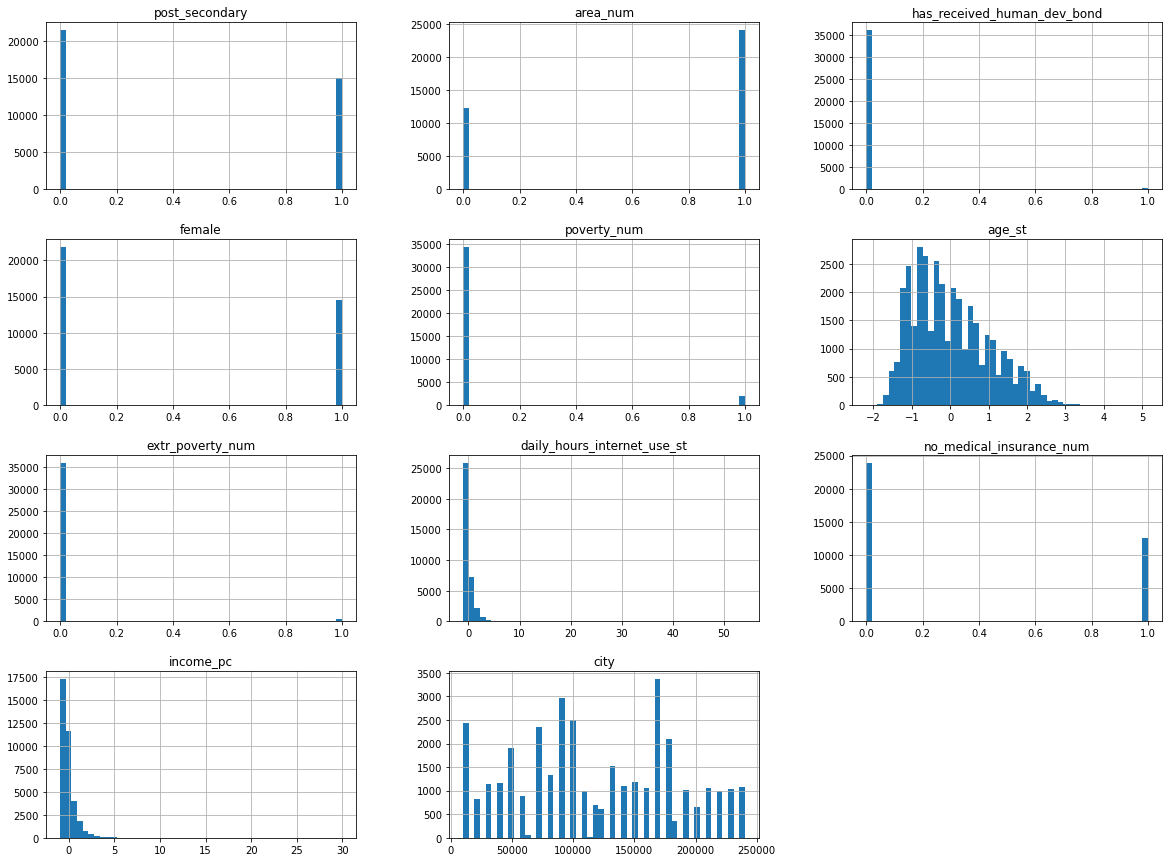

In [6]:
fig =plt.figure()
data_filtered.hist(bins=50, figsize=(20,15))
plt.savefig('Histograms_area.png')
plt.show()

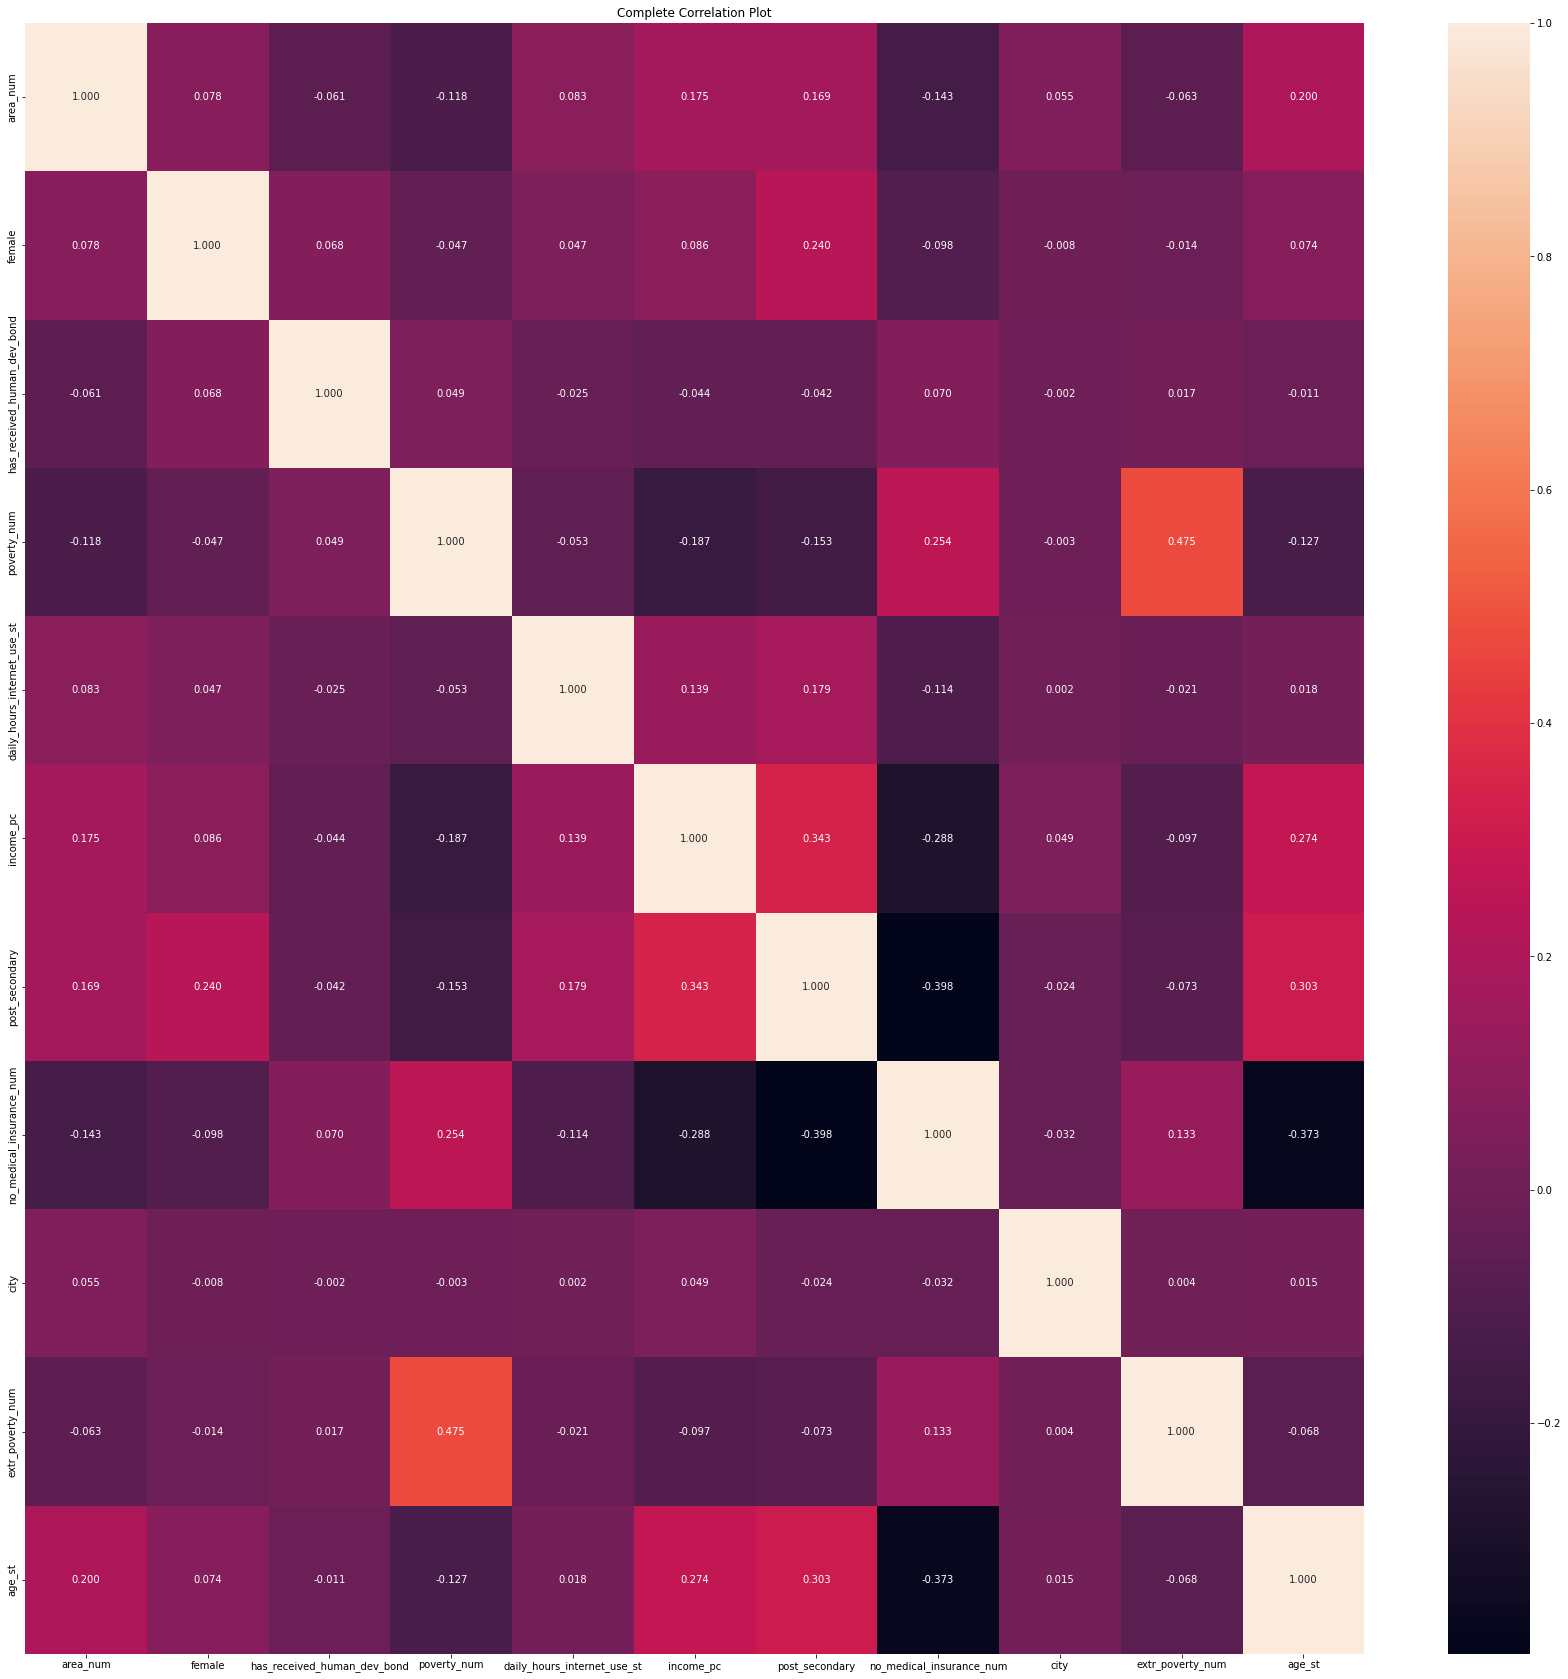

In [7]:
##Correlation Plot for Everything

data_filtered_copy = data_filtered[[ 'area_num','female', 'has_received_human_dev_bond',
       'poverty_num', 'daily_hours_internet_use_st', "income_pc", "post_secondary",
       'no_medical_insurance_num', 'city',"extr_poverty_num","age_st"]]
corr = data_filtered_copy.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title("Complete Correlation Plot")
plt.savefig('complete_correlations_area.png')
plt.show()

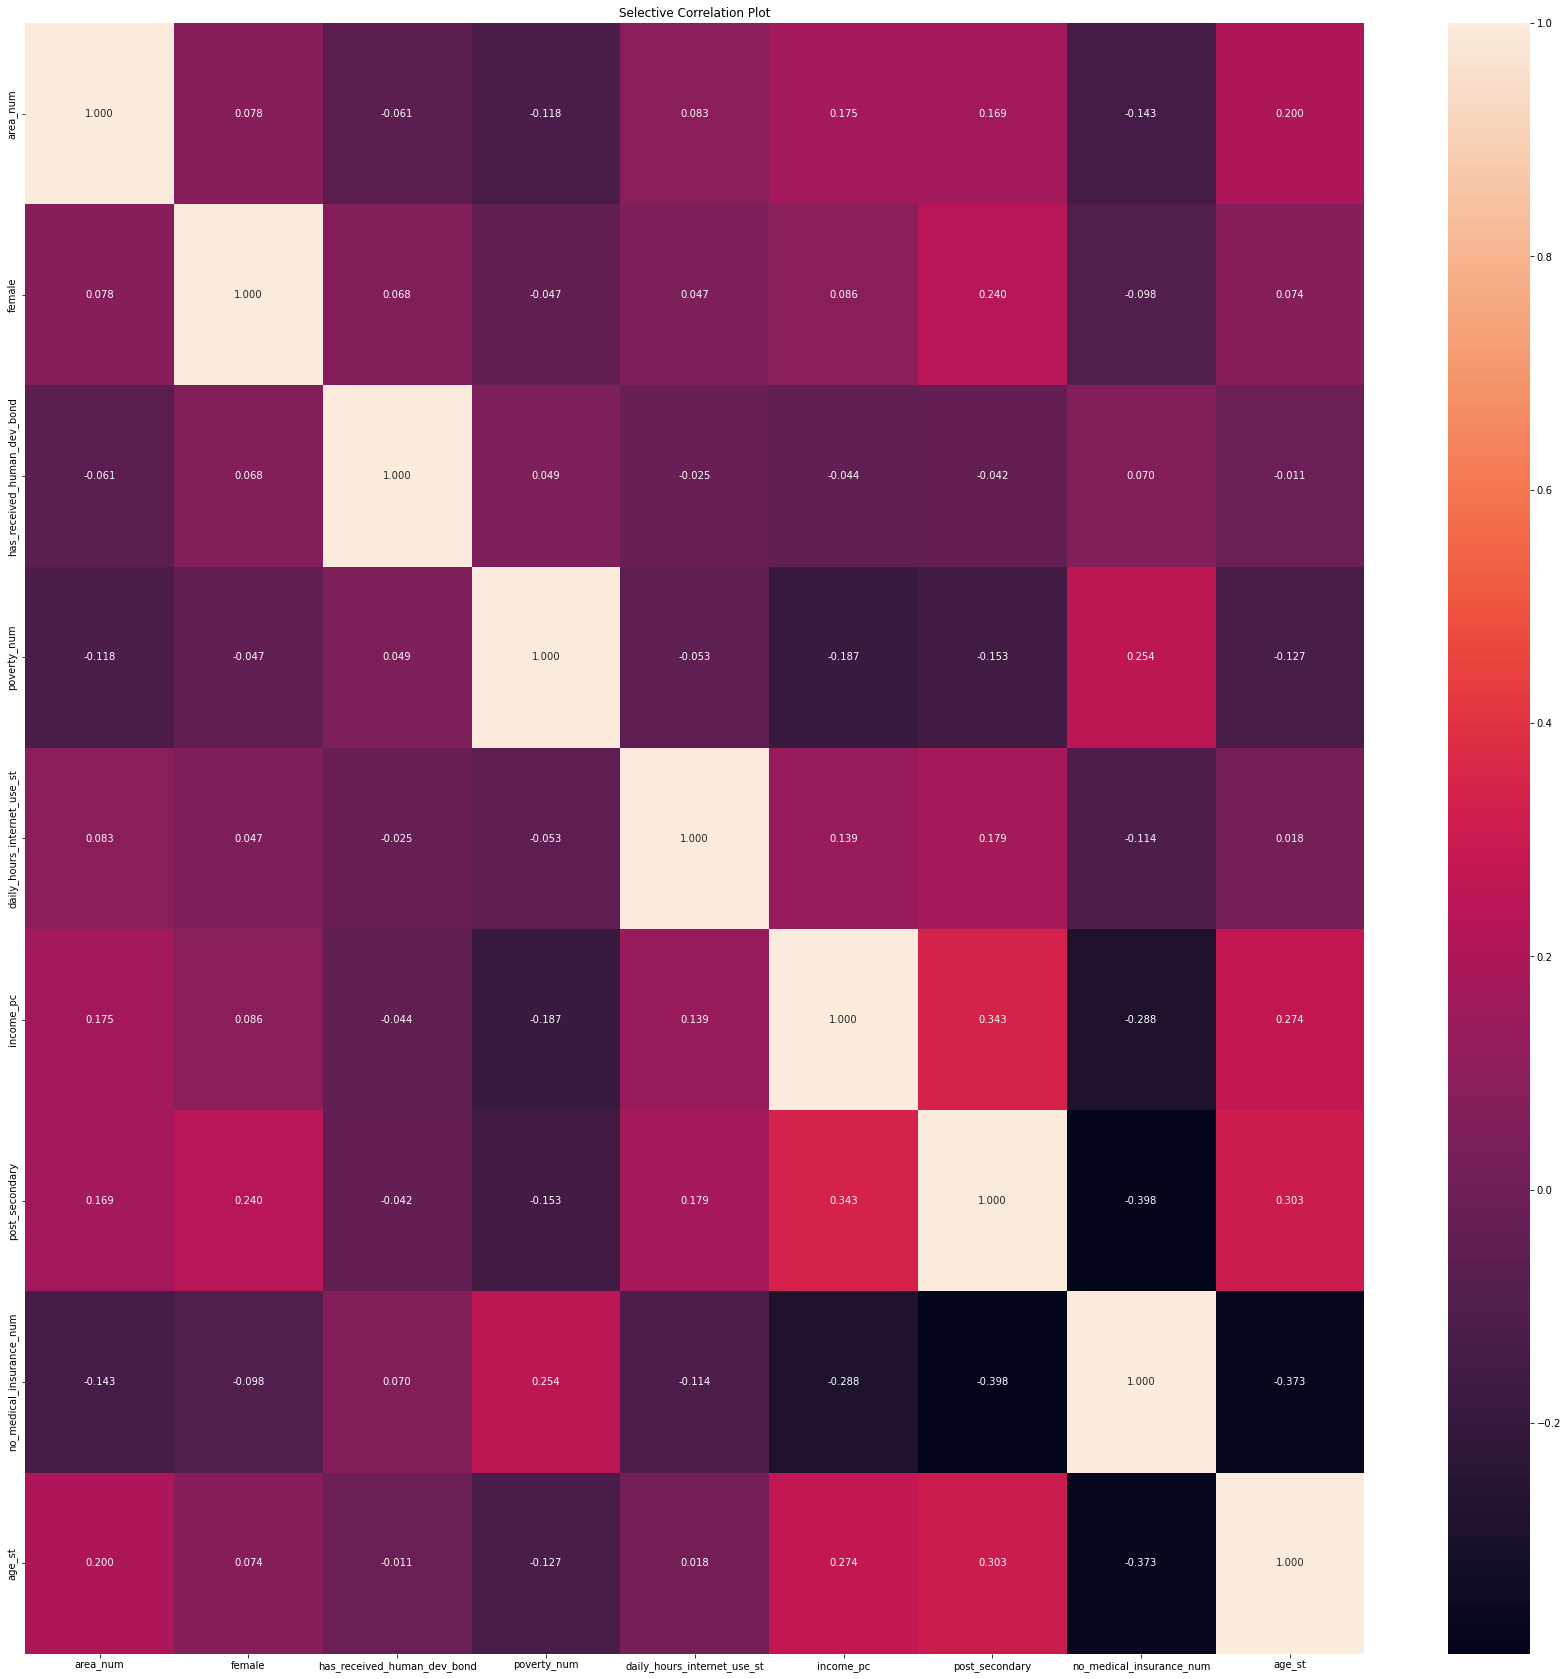

In [8]:
##Focused Correlations

data_filtered_copy = data_filtered[['area_num', 'female', 'has_received_human_dev_bond',
       'poverty_num', 'daily_hours_internet_use_st', "income_pc", "post_secondary",
       'no_medical_insurance_num','age_st']]
corr = data_filtered_copy.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title("Selective Correlation Plot")
plt.savefig('selective_correlations_area.png')
plt.show()

In [9]:
## Getting x-features and y as the outcomes
x = data_filtered.iloc[:,1:-1]
y = data_filtered["post_secondary"]
x.head()

,area_num,has_received_human_dev_bond,female,poverty_num,age_st,extr_poverty_num,daily_hours_internet_use_st,no_medical_insurance_num,income_pc
429172,0.0,0.0,0,0,0.906759,0.0,-0.585906,0.0,-0.360216
429174,0.0,0.0,0,0,-0.951063,0.0,-0.585906,0.0,-0.360216
429177,0.0,0.0,0,0,-0.243322,0.0,-0.585906,0.0,-0.491827
429178,0.0,1.0,1,0,-0.420257,0.0,-0.585906,1.0,-0.491827
429184,0.0,0.0,0,0,-0.508725,0.0,-0.585906,0.0,-0.373651


In [10]:
## Data preparation (splitting)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

In [11]:
##Number of Data Samples len(X_train)=60636 with total number being 71337

In [12]:
## Starting with a simple Logistic Regression
model=sm.Logit(y,x)
result=model.fit()
result.summary()
with open('summary_logit_area.txt', 'w') as fh:
    fh.write(result.summary().as_text())
fh.close()

Optimization terminated successfully.
         Current function value: 0.513725
         Iterations 6


In [13]:
## Training an SVM with RBF kernel on the data and evaluating accuracy.
svm_linear = svm.SVC(kernel='rbf')
# fit
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
# measure accuracy
svm_acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [14]:
## Training Gradient Boosting Reg on the data and evaluating accuracy.
regressor=GradientBoostingRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
gradboost_acc=metrics.roc_auc_score(y_test,y_pred)


In [15]:
## Training an Random Forest Reg on the data and evaluating accuracy.
regressor=RandomForestRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
randomforest_acc = metrics.roc_auc_score(y_test,y_pred)

In [16]:
## Training an AdaBoost Reg on the data and evaluating accuracy.
regressor=AdaBoostRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
adaboost_acc = metrics.roc_auc_score(y_test,y_pred)

In [17]:
## Let's compare to when we have the socioeconomic
data_filtered_se = data_filtered[["post_secondary","area_num", "has_received_human_dev_bond","female",'age_st',"no_medical_insurance_num",
          "income_pc"]]
    
    #[ "post_secondary",'female', 'has_received_human_dev_bond', "income_pc",
    #   'age_st']]

x_se = data_filtered_se.iloc[:,1:]
y_se = data_filtered_se["post_secondary"]
x_se.head()

,area_num,has_received_human_dev_bond,female,age_st,no_medical_insurance_num,income_pc
429172,0.0,0.0,0,0.906759,0.0,-0.360216
429174,0.0,0.0,0,-0.951063,0.0,-0.360216
429177,0.0,0.0,0,-0.243322,0.0,-0.491827
429178,0.0,1.0,1,-0.420257,1.0,-0.491827
429184,0.0,0.0,0,-0.508725,0.0,-0.373651


In [18]:
## Data preparation (splitting)
X_train, X_test, y_train, y_test = train_test_split(x_se, y_se, test_size = 0.15)

In [19]:
## Training an SVM with RBF kernel on the data and evaluating accuracy.
svm_linear = svm.SVC(kernel='rbf')
# fit
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
# measure accuracy
svm_acc_se = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

## Training Gradient Boosting Reg on the data and evaluating accuracy.
regressor=GradientBoostingRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
gradboost_acc_se=metrics.roc_auc_score(y_test,y_pred)

## Training an Random Forest Reg on the data and evaluating accuracy.
regressor=RandomForestRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
randomforest_acc_se = metrics.roc_auc_score(y_test,y_pred)

## Training an AdaBoost Reg on the data and evaluating accuracy.
regressor=AdaBoostRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
adaboost_acc_se = metrics.roc_auc_score(y_test,y_pred)

In [20]:
## Scores' Display

scores=[[svm_acc_se,svm_acc],[gradboost_acc_se,gradboost_acc],[randomforest_acc_se,randomforest_acc],[adaboost_acc_se,adaboost_acc]]
with open('model_comparisons_area.txt', 'w') as fh:
    fh.write(str(scores))
fh.close()

In [21]:
scores

[[0.7556734992679356, 0.7776354319180088],
 [0.8310079369832144, 0.8582057431748398],
 [0.7861775529871534, 0.8160211491776829],
 [0.8162772615467192, 0.8349684355689703]]

In [22]:
## Post secondary variable with city
city_col = data_filtered['city']
post_sec_col = data_filtered['post_secondary']
city_post_sec = pd.concat([city_col,post_sec_col], axis=1)
city_post_sec.describe()

,city,post_secondary
count,36426.000000,36426.000000
mean,118540.222890,0.411931
std,65219.707659,0.492190
min,10150.000000,0.000000
25%,70150.000000,0.000000
50%,110156.000000,0.000000
75%,170184.000000,1.000000
max,240352.000000,1.000000


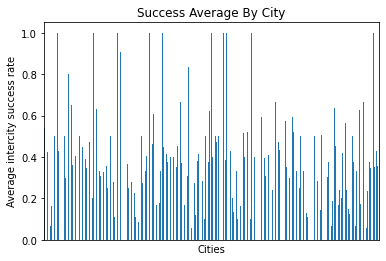

In [23]:
## Success rate by city

df=city_post_sec.groupby("city").describe()
df = df["post_secondary"]
plt.figure()
df["mean"].plot.bar()
plt.ylabel('Average intercity success rate')
ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
ax.axes.xaxis.set_ticks([])
plt.xlabel('Cities')
plt.title('Success Average By City')
plt.savefig('successaveragebycity_area.png')
plt.show()

In [24]:
## We construct a DF with internet usage, post secondary details and city, the group by city
internet= data_filtered['daily_hours_internet_use_st']
city_ps_int = pd.concat([city_col,post_sec_col,internet], axis=1)
city_ps_int.describe()
df=city_ps_int.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_int = df["daily_hours_internet_use_st"]
df_int['internet'] = df_int["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_int['internet']],axis=1)
dfi.export(corr_df.corr(),'city_ps_internet_corr_area.png')
corr_df.corr()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/3428473063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/3428473063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['internet'] = df_int["mean"]
[0328/102534.012642:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpl4_9tpku/temp.png.


,post_secondary,internet
post_secondary,1.000000,0.159641
internet,0.159641,1.000000


In [25]:
## We construct a DF with internet usage, post secondary details and city, the group by city
income= data_filtered['income_pc']
city_ps_inc = pd.concat([city_col,post_sec_col,income], axis=1)
df=city_ps_inc.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_inc = df["income_pc"]
df_inc['income_pc'] = df_inc["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_inc['income_pc']],axis=1)
dfi.export(corr_df.corr(),'city_ps_income_corr_area.png')
corr_df.corr()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/4090682440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/4090682440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inc['income_pc'] = df_inc["mean"]
[0328/102537.231378:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmp4wybkoj9/temp.png.


,post_secondary,income_pc
post_secondary,1.000000,0.382626
income_pc,0.382626,1.000000


In [26]:
## We construct a DF with internet usage, post secondary details and city, the group by city

age= data_filtered['age_st']
city_ps_age = pd.concat([city_col,post_sec_col,age], axis=1)
df=city_ps_age.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_age = df["age_st"]
df_age['age'] = df_age["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_age['age']],axis=1)
dfi.export(corr_df.corr(),'city_ps_age_corr_area.png')
corr_df.corr()


/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/1956184123.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/1956184123.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['age'] = df_age["mean"]
[0328/102541.019415:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmp0rv3646c/temp.png.


,post_secondary,age
post_secondary,1.000000,0.452912
age,0.452912,1.000000


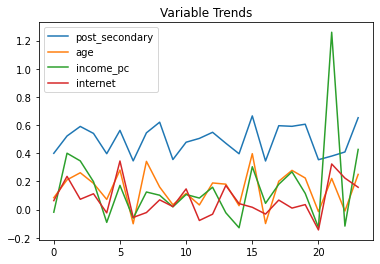

In [27]:
## Non binary trends' plots
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet']],axis=1)
sort_count=sort_count.sort_values('count',ascending=False) 
sort_count=sort_count[sort_count['count']>250]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area.png')
plt.show()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/694553880.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/694553880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area['area'] = df_area["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/694553880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

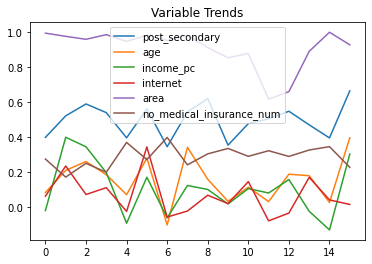

In [28]:
##Plots for all trends presumed to be interested/informative.

area= data_filtered['area_num']
nomed_insur = data_filtered["no_medical_insurance_num"]
city_ps_age = pd.concat([city_col,post_sec_col,area,nomed_insur], axis=1)
df=city_ps_age.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_area = df["area_num"]
df_area['area'] = df_area["mean"]

df_med = df['no_medical_insurance_num']
df_med['no_medical_insurance_num'] = df_med["mean"]

## Non binary
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet'], df_area['area'],df_med['no_medical_insurance_num']],axis=1)
sort_count=sort_count.sort_values('count',ascending=False) 
sort_count=sort_count[sort_count['count']>400]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area_wf_med.png')
plt.show()

In [36]:
%%capture
## Data import

data_ = Imputation.data.reset_index()
data_['income_pc'] = StandardScaler().fit_transform(data_['income_pc'].values.reshape((-1, 1)))
data_['daily_hours_internet_use_st'] = StandardScaler().fit_transform(data_['daily_hours_internet_use_st'].values.reshape((-1, 1)))
data_ = data_[data_['city'] < 400000]
data_['age_st'] = StandardScaler().fit_transform(data_['age_st'].values.reshape((-1, 1)))
data_ = data_.drop_duplicates()



In [37]:
def data_process(name,data_) :
## Filtering columns of interest
## endog - variable of interest
## exog - attributes, and cluster --city label
    endog = ["post_secondary"]
    clusters = ["city"]

    if name=="econ" :
        exog = ["area_num", "has_received_human_dev_bond","female",'age_st',"no_medical_insurance_num",
          "income_pc"]#,  "security_neighb", "security_city",
          #"sad_due_to_LowIncome","social_security"]
        data_filtered = data_.loc[:, endog + exog + clusters].dropna(subset=  endog + exog + clusters)


    else :

        exog = ["area_num", "has_received_human_dev_bond","female",
          "poverty_num", "age_st","extr_poverty_num","daily_hours_internet_use_st", "no_medical_insurance_num", "income_pc"]#,  "security_neighb", "security_city",
          #"sad_due_to_LowIncome","social_security"]
        data_filtered = data_.loc[:, endog + exog + clusters].dropna(subset=  endog + exog + clusters)


    ## Getting x-features and y as the outcomes
    x = data_filtered.iloc[:,1:-1]
    y = data_filtered["post_secondary"]

    ## Data preparation (splitting)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)
    return (X_train,X_test,y_train,y_test,list(data_filtered.columns))



In [38]:
from sklearn.ensemble import AdaBoostClassifier 

def evaluate_model(X_train,X_test,y_train,y_test,cols):
    ## Training an AdaBoost Reg on the data and evaluating accuracy.
    regressor=AdaBoostClassifier()
    # fit
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    # measure accuracy
    adaboost_acc_se = metrics.roc_auc_score(y_test,y_pred)

    y_test_ = np.asarray(y_test)
    misclassified = np.argwhere(y_test_ != y_pred)
    classified = np.argwhere(y_test_ == y_pred)


    return adaboost_acc_se,regressor,misclassified,X_test,y_test,cols,classified

    

In [39]:
model1acc,model1mod,model1misscl,model1xtest,model1ytest,cols1,classm1=evaluate_model(*data_process('econ',data_))
model2acc,model2mod,model2misscl,model2xtest,model2ytest,cols2,classm2=evaluate_model(*data_process('social',data_))



In [40]:
model1acc, model2acc

(0.7515135806856569, 0.7616165478813297)

In [41]:
model1misscl=[x[0] for x in list(model1misscl)]
model2misscl=[x[0] for x in list(model2misscl)]
model1cl=[x[0] for x in classm1]
model2cl=[x[0] for x in classm2]

In [42]:


model1xtest=model1xtest.iloc[model1misscl]
model2xtest=model2xtest.iloc[model2misscl]



datam1_filter  = data_.loc[data_.index.isin(model1xtest.index)]
datam2_filter  = data_.loc[data_.index.isin(model2xtest.index)]

In [43]:
datam1f_cross_cols2=datam1_filter.loc[:, cols2].dropna(subset=  cols2)
datam2f_cross_cols1=datam2_filter.loc[:, cols1].dropna(subset=  cols1)



In [44]:
datam2f_cross_cols1


,post_secondary,area_num,has_received_human_dev_bond,female,age_st,no_medical_insurance_num,income_pc,city
429191,1,0.0,1.0,1,-0.085118,1.0,-0.071796,10151
429656,1,0.0,0.0,0,0.006188,0.0,0.576783,10160
429844,1,0.0,0.0,1,-0.176424,1.0,0.224552,10162
431081,0,0.0,0.0,1,0.508370,0.0,0.503966,11551
432432,1,0.0,0.0,0,0.508370,0.0,-0.049782,20150
...,...,...,...,...,...,...,...,...
1112392,1,1.0,0.0,0,-0.130771,1.0,0.689395,240250
1113185,1,1.0,0.0,0,0.006188,0.0,0.116738,240350
1113640,1,1.0,0.0,1,-0.085118,1.0,-0.044701,240351
1113747,1,1.0,0.0,0,0.645329,1.0,1.059407,240351


In [45]:


datam1f_crossc2_x=datam1f_cross_cols2.iloc[:,1:-1]
datam1f_crossc2_y=datam1f_cross_cols2["post_secondary"]

datam2f_crossc1_x=datam2f_cross_cols1.iloc[:,1:-1]
datam2f_crossc1_y=datam2f_cross_cols1["post_secondary"]

In [46]:
datam1f_crossc2_x

,area_num,has_received_human_dev_bond,female,poverty_num,age_st,extr_poverty_num,daily_hours_internet_use_st,no_medical_insurance_num,income_pc
429347,0.0,0.0,0,0,-0.313383,0.0,-0.026757,0.0,0.229632
429481,0.0,0.0,0,0,0.371411,0.0,-0.485928,0.0,0.139317
429651,0.0,0.0,0,0,0.554023,0.0,-0.485928,0.0,1.330354
429844,0.0,0.0,1,0,-0.176424,0.0,-0.485928,1.0,0.224552
430142,0.0,0.0,0,0,-0.176424,0.0,-0.485928,0.0,0.190119
...,...,...,...,...,...,...,...,...,...
1112473,1.0,0.0,1,0,-0.313383,0.0,-0.026757,0.0,0.604894
1112489,1.0,0.0,0,0,0.234452,0.0,-0.026757,1.0,-0.205012
1112860,1.0,0.0,1,0,-0.495995,0.0,0.432414,0.0,0.332205
1112887,1.0,0.0,0,0,0.508370,0.0,-0.485928,0.0,0.873978


data2mf_crossc1_x

In [47]:
y_pred_1on2=model1mod.predict(datam2f_crossc1_x)
error1on2=metrics.roc_auc_score(datam2f_crossc1_y,y_pred_1on2)
classified_1on2 = np.argwhere(np.array(datam2f_crossc1_y) == y_pred_1on2)
error1on2

0.22295181713963394

In [48]:
y_pred_2on1=model2mod.predict(datam1f_crossc2_x)
error2on1=metrics.roc_auc_score(datam1f_crossc2_y,y_pred_2on1)
classified_2on1 = np.argwhere(np.array(datam1f_crossc2_y) == y_pred_2on1)
error2on1


0.2582874817978363

In [49]:
classified_1on2_=[x[0] for x in classified_1on2]
classified_2on1_ =[x[0] for x in classified_2on1]

set_that_mod_econ_improves = datam2f_cross_cols1.iloc[classified_1on2_]
set_that_mod_soc_improves = datam1f_cross_cols2.iloc[classified_2on1_]

In [50]:
set_that_mod_econ_improves.describe().T

,count,mean,std,min,25%,50%,75%,max
post_secondary,265.0,0.275472,0.447597,0.000000,0.000000,0.000000,1.000000,1.000000
area_num,265.0,0.679245,0.467650,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,265.0,0.003774,0.061430,0.000000,0.000000,0.000000,0.000000,1.000000
female,265.0,0.471698,0.500143,0.000000,0.000000,0.000000,1.000000,1.000000
age_st,265.0,0.303363,0.502436,-0.541648,-0.130771,0.234452,0.690982,1.649694
no_medical_insurance_num,265.0,0.105660,0.307984,0.000000,0.000000,0.000000,0.000000,1.000000
income_pc,265.0,0.592704,0.571994,-0.411326,0.188143,0.536141,0.869744,4.764605
city,265.0,125706.177358,65069.989389,10150.000000,80150.000000,121050.000000,180150.000000,240350.000000


<Figure size 432x288 with 0 Axes>

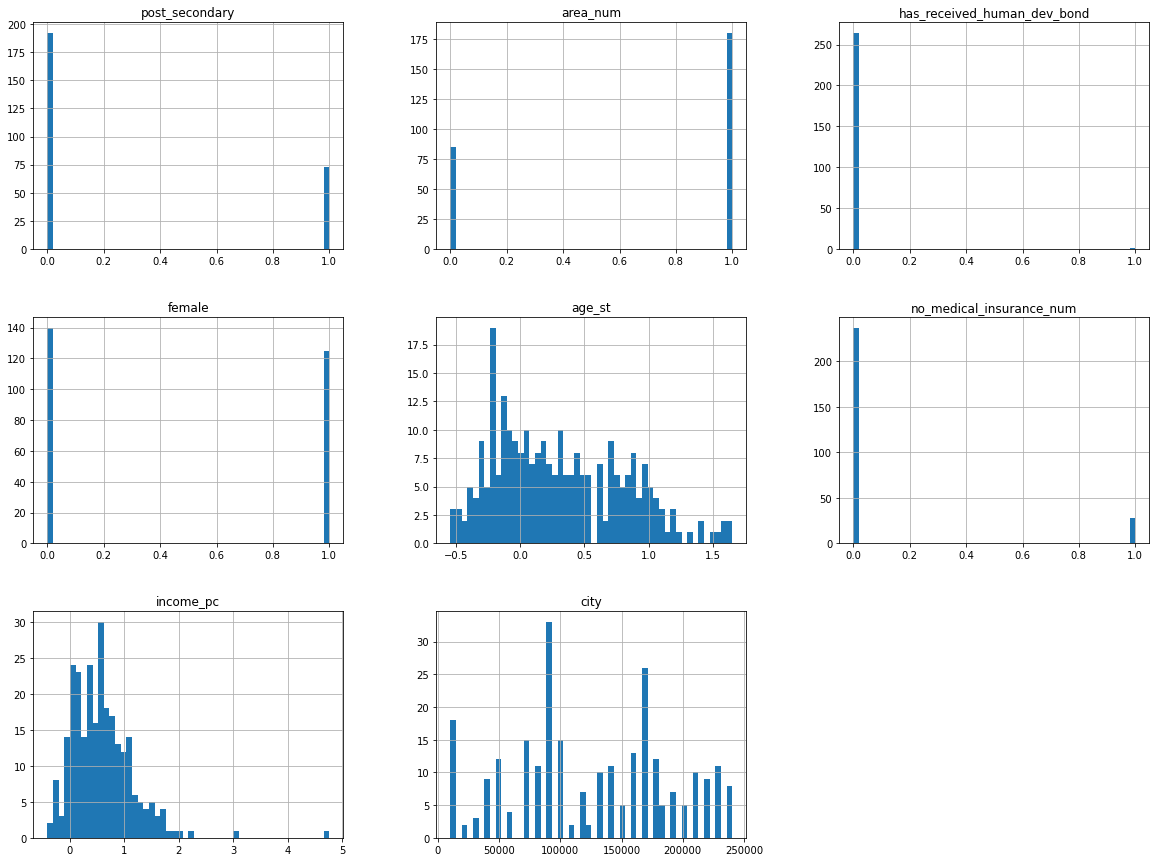

In [51]:
fig =plt.figure()
set_that_mod_econ_improves.hist(bins=50, figsize=(20,15))
plt.savefig('Histograms_area.png')
plt.show()

In [52]:
set_that_mod_soc_improves.describe().T

,count,mean,std,min,25%,50%,75%,max
post_secondary,383.0,0.788512,0.408898,0.000000,1.000000,1.000000,1.000000,1.000000
area_num,383.0,0.689295,0.463388,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,383.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
female,383.0,0.420366,0.494263,0.000000,0.000000,0.000000,1.000000,1.000000
poverty_num,383.0,0.005222,0.072168,0.000000,0.000000,0.000000,0.000000,1.000000
age_st,383.0,0.454969,0.564415,-0.495995,-0.039465,0.417064,0.919247,1.923611
extr_poverty_num,383.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
daily_hours_internet_use_st,383.0,0.425220,1.111879,-0.485928,-0.485928,-0.026757,0.891585,8.238319
no_medical_insurance_num,383.0,0.065274,0.247332,0.000000,0.000000,0.000000,0.000000,1.000000
income_pc,383.0,0.621330,0.594371,-0.383385,0.236406,0.509046,0.924357,3.950635


<Figure size 432x288 with 0 Axes>

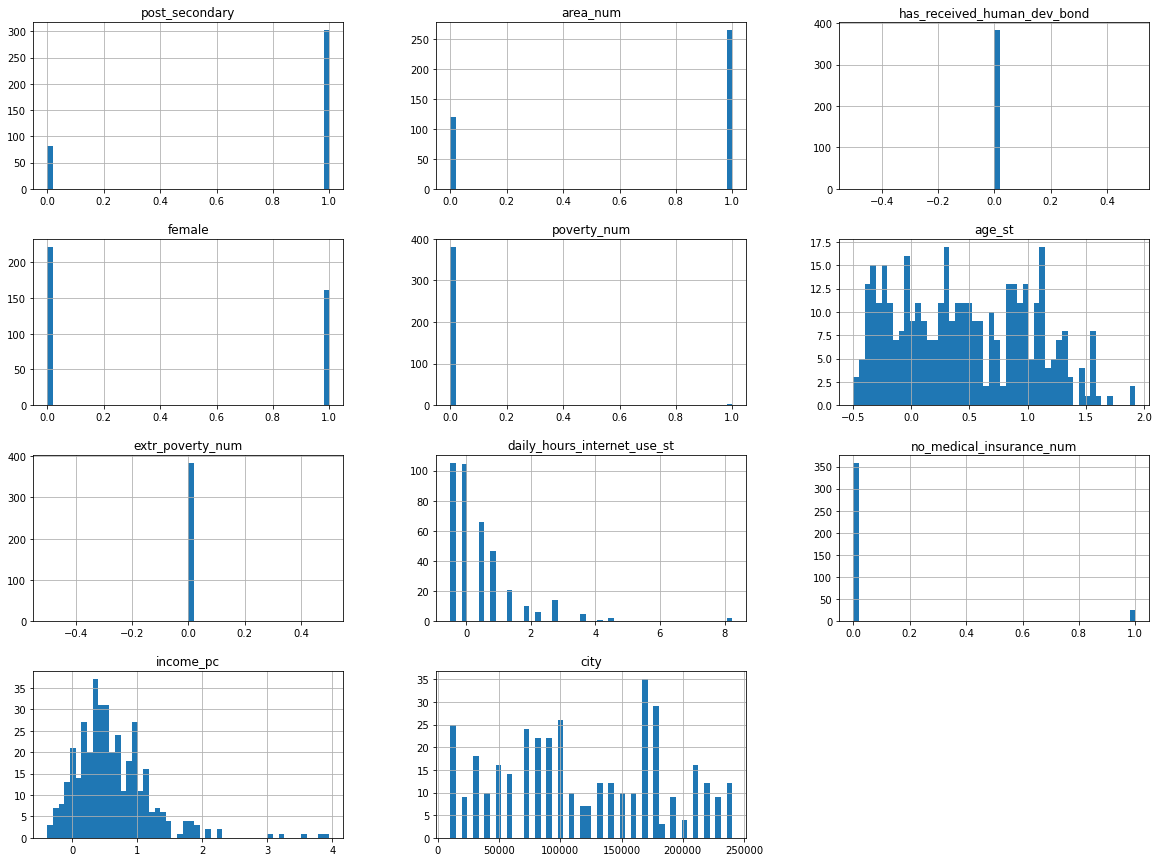

In [53]:
fig =plt.figure()
set_that_mod_soc_improves.hist(bins=50, figsize=(20,15))
plt.savefig('Histograms_area.png')
plt.show()

In [54]:
overlap=[]
for idx in range(len(list(set_that_mod_soc_improves))):
    if list(set_that_mod_soc_improves.index)[idx] in list(set_that_mod_econ_improves.index):
        overlap.append(list(set_that_mod_soc_improves.index)[idx])
overlap

[]

NEED TO USE classified_1on2  AND OTHER TO GET INDICES WITH ALL COLS FROM DATA_ THEN USE THEM BELOW.... :( ; Think it's fine now, but I need to reread everything.

In [55]:
 
data_filtered = data_.loc[ list(set_that_mod_econ_improves.index)]
data_filtered.head()


,level_0,index,id_p,area,city,conglomerado,panelm,household_id,home_id,person,...,female,area_num,poverty_num,extr_poverty_num,no_medical_insurance_num,missing_level_of_education,missing_poverty,income_tot,income_pct_change,income_imp
498489,498489,71703,18075699902201121,rural,180756,NaN,11,2,1,3,...,0,0.0,0,0.0,1.0,0,0,800.0,-0.146953,697.5
598508,598508,20683,06035099903122231,rural,60350,NaN,222,3,1,2,...,1,0.0,0,0.0,0.0,0,0,150.0,0.544073,329.0
603293,603293,25468,07065300100219221,rural,70653,NaN,192,2,1,1,...,1,0.0,0,0.0,0.0,0,0,500.0,-1.777778,180.0
604561,604561,26736,07115099900322211,rural,71150,NaN,222,1,1,2,...,1,0.0,0,0.0,0.0,0,0,320.0,-0.758242,182.0
608888,608888,31063,08035299900122211,rural,80352,NaN,222,1,1,2,...,1,0.0,0,0.0,0.0,0,0,250.0,-0.470588,170.0


In [56]:
set_that_mod_econ_improves.head()

,post_secondary,area_num,has_received_human_dev_bond,female,age_st,no_medical_insurance_num,income_pc,city
498489,0,0.0,0.0,0,0.188800,1.0,1.728307,180756
598508,0,0.0,0.0,1,0.873594,0.0,0.480258,60350
603293,0,0.0,0.0,1,0.873594,0.0,-0.024380,70653
604561,0,0.0,0.0,1,-0.130771,0.0,-0.017607,71150
608888,0,0.0,0.0,1,0.371411,0.0,-0.058249,80352


/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2624925220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2624925220.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['age'] = df_age["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2624925220.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

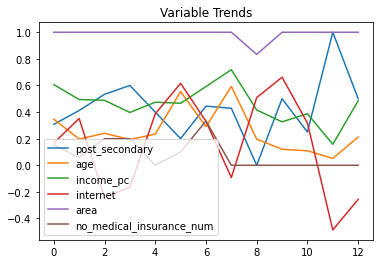

In [57]:
##Plots for all trends presumed to be interested/informative.
data_filtered = data_.loc[ list(set_that_mod_econ_improves.index)]
## Post secondary variable with city

df=data_filtered.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level

## We construct a DF with internet usage, post secondary details and city, the group by city


## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_age = df["age_st"]
df_age['age'] = df_age["mean"]


df_int = df["daily_hours_internet_use_st"]
df_int['internet'] = df_int["mean"]


df_inc = df["income_pc"]
df_inc['income_pc'] = df_inc["mean"]


df_area = df["area_num"]
df_area['area'] = df_area["mean"]

df_med = df['no_medical_insurance_num']
df_med['no_medical_insurance_num'] = df_med["mean"]

## Non binary
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet'], df_area['area'],df_med['no_medical_insurance_num']],axis=1)
sort_count=sort_count.sort_values('count',ascending=False) 
sort_count=sort_count[sort_count['count']>3]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area_wf_med.png')
plt.show()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2363281789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2363281789.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['age'] = df_age["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_59866/2363281789.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

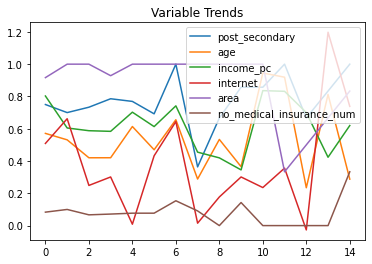

In [58]:
##Plots for all trends presumed to be interested/informative.
data_filtered = data_.loc[ list(set_that_mod_soc_improves.index)]
## Post secondary variable with city

df=data_filtered.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level

## We construct a DF with internet usage, post secondary details and city, the group by city


## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_age = df["age_st"]
df_age['age'] = df_age["mean"]


df_int = df["daily_hours_internet_use_st"]
df_int['internet'] = df_int["mean"]


df_inc = df["income_pc"]
df_inc['income_pc'] = df_inc["mean"]


df_area = df["area_num"]
df_area['area'] = df_area["mean"]

df_med = df['no_medical_insurance_num']
df_med['no_medical_insurance_num'] = df_med["mean"]

## Non binary
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet'], df_area['area'],df_med['no_medical_insurance_num']],axis=1)
sort_count=sort_count.sort_values('count',ascending=False) 
sort_count=sort_count[sort_count['count']>5]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area_wf_med.png')
plt.show()

In [59]:
set_that_mod_econ_improves

,post_secondary,area_num,has_received_human_dev_bond,female,age_st,no_medical_insurance_num,income_pc,city
498489,0,0.0,0.0,0,0.188800,1.0,1.728307,180756
598508,0,0.0,0.0,1,0.873594,0.0,0.480258,60350
603293,0,0.0,0.0,1,0.873594,0.0,-0.024380,70653
604561,0,0.0,0.0,1,-0.130771,0.0,-0.017607,71150
608888,0,0.0,0.0,1,0.371411,0.0,-0.058249,80352
...,...,...,...,...,...,...,...,...
1108473,1,1.0,0.0,0,-0.085118,0.0,0.589314,230150
1108474,1,1.0,0.0,0,-0.222077,0.0,0.589314,230150
1108742,1,1.0,0.0,1,-0.313383,0.0,0.325593,230150
1110645,1,1.0,0.0,1,0.051841,0.0,0.081095,240152


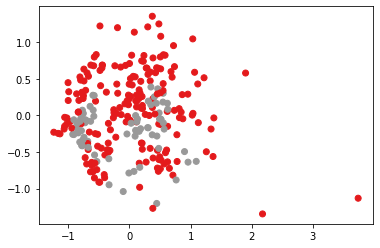

In [60]:
## Start with PCA import and transform

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(set_that_mod_econ_improves.iloc[:,1:-1])
X_train_red=pca.transform(set_that_mod_econ_improves.iloc[:,1:-1])

##Here is the needed plot
plt.scatter(X_train_red[:,0],X_train_red[:,1],c=set_that_mod_econ_improves['post_secondary'],  cmap='Set1')
plt.show()

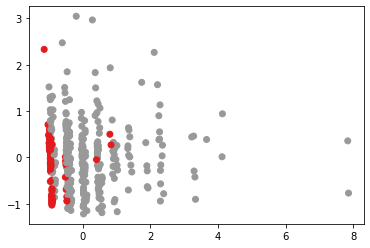

In [61]:
## Start with PCA import and transform

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(set_that_mod_soc_improves.iloc[:,1:-1])
X_train_redsc=pca.transform(set_that_mod_soc_improves.iloc[:,1:-1])
##Here is the needed plot
plt.scatter(X_train_redsc[:,0],X_train_redsc[:,1],c=set_that_mod_soc_improves['post_secondary'],  cmap='Set1')
plt.show()

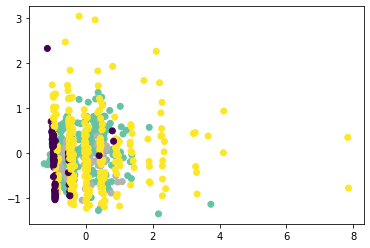

In [62]:
fig=plt.figure()
plt.scatter(X_train_red[:,0],X_train_red[:,1],c=set_that_mod_econ_improves['post_secondary'],  cmap='Set2')
plt.scatter(X_train_redsc[:,0],X_train_redsc[:,1],c=set_that_mod_soc_improves['post_secondary'])
plt.show()